In [49]:
#fundamental tools for the game environment model
import numpy as np
import multiprocess
from multiprocess import Process, Queue, Semaphore, Lock
import time
import random

# for visualations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from randomchooser import Chooser
from exploresims import simulate_explore, sim_1, demo_1, demo_2
import explore

pygame 2.5.1 (SDL 2.28.2, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


When training a Reinforcement Learning (RL) model using a variation of Temporal Difference Error and discrete actions, it is overwhelmingly common to both emphasize the importance of input/action variance and to control output variance and bias.

One is far more likely to encounter discussion, advice, and research pertaining to the controlling of the variance in the outputs of a model. This is the so-called Variance or Bias Tradeoff (VBT). The problem here is of course the repetitive use of the term Variance, but given its statistical significance this is mostly unavoidable.

This discussion and its accompanying demonstrations are focused on the other side of the spectrum. The variance of the experiences provided to the model during training. How actions are selected and its impact on model convergence, and potentially the quality of the policy, overall.

For simplicity of the demonstrations, we shall focus our considerations to RL models most similar to DQN models utilizing algorithms that mathematically resemble the Epsilon Greedy Strategy and Experience Replay Memory in line with Bellman Equation based policy optimizations (i.e. Deep Reinforcement Learning / Deep Q-Learning).

Note this restriction is arbitrary and simply serves to limit the scope of the demonstration, to keep things accessible, apologies to the more advanced reader.

Unlike the plethora of sources that discuss the Variance Bias Tradeoff of outputs, there are far less discussions on maximizing or minimizing the variance of actions selected by the model during its exploratory phases. It is quite the norm for texts, tutorials, examples, and the like to simply select a uniform distribution, justify it as being mathematically the highest variance, and therefore the least biased towards any one action type for the model to explore and move on.

This is fine in theory, it feels intuitive, however this trend should not go unchallenged simply for its face value.

The reasoning here is that we want high variance in the random actions selected during exploration. The point is that we want the model, for a time, to make entirely random moves. These moves should not "prefer" any one action and build a stored memory of experiences. Then we slowly allow the model to take its own actions and converge on some strategy. This is the fundamental idea behind the Epsilon Greedy strategy.

High variance in the random selection ensures a diverse set of experiences and the uniform nature of the distribution prevents bias in examples. This is why the common assumption is so intuitive and is rarely strayed from, or challenged.

To avoid this from being an endless drone, lets dip our toes in and  see some demonstrations and other visualizations. To this end I have put together a small game, called Explore. It is like a simple maze game, where an agent, or player, is represented by a blue square and must navigate to the exit or goal, represented by the green square.
There may be some number of gray walls obstructing the agent's path, but a path to the goal will always exist.
The agent may only choose to move up, down, left, right, or do nothing.

For visualization purposes the animation includes a trace or heatmap of the number of times a square has been visited. This matrix is then normalized such that the most visited square is always full white, and unvisited squares are fully black.
Please run the next cell and observe this first agent "play". I won't mention what algorithm may be at play here, yet, but know the moves are entirely random.
10 games will be simulated, up to 80 moves each. The trace will be totaled over all 10 games.

Note these first two demos will not have the walls in play.
The windows will hold the result for a few seconds before closing so you can view the final heatmap. Focus on the look and feel of the gameplay you see.

In [45]:
sample_1 = demo_1()

In [46]:
# Now watch this other demo
sample_2 = demo_2()

Okay now watch them again, but with the walls present so you can see what the game would be like in general. If an agent gets to the goal, it progresses to the next "floor". As in a new map, and goal location is generated. You may have seen the goal move earlier when touched, but now it will include a whole new map. Reaching the goal 10 times is the offical "win" condition of the game.

In [47]:
t = demo_1(rebuild=True)
t = demo_2(rebuild=True)

Okay so now you have watched two different "agents" play a few games. I already told you the first one was random . . . but would you beleive me if I told you the second one was equally as random?

Assuming you are infact willing to beleive me, here is a question I want you to ponder.

Which one was more random?

Feel free to watch them play again if you like but don't get to caught up in trying to guess correctly. The nebulous nature of this randomness is indeed the reason for this demo.

Okay here is another question, which heatmap or trace, the thing on the right of the viewing window looks the most variable?

Don't worry we saved them earlier so you don't have to keep running the simualtion to look at them. Run the next cell block.

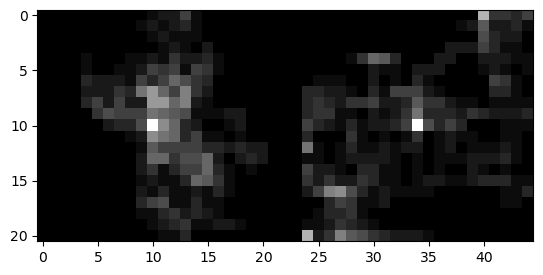

In [43]:
#This is just some postprocessing for drawing the heat maps
heat_1 = sample_1[0][4].copy()
heat_2 = sample_2[0][4].copy()

# normalizing here to retain relative maxima brightness for each map
# imshow also runs a normalize 
# and would use the max out of both maps to normalize both
# If you are interested, you can try commenting them out
# but randomness plays a role here as well
heat_1 *= 255/heat_1.max()
heat_2 *= 255/heat_2.max()

# To visually separate the two heat maps
spacer = np.zeros((21,3))

img = np.hstack([heat_1, spacer, heat_2])
plt.imshow(img, cmap="gray")

Ok so the gotchya here, if you can call it that, is that they are both entirely random. Seriously! 

In fact they are actually EQUALLY random from a macro perspective of action selection. It may be hard to beleive, depending on how your individual simualtions went but it is indeed true and this becomes the crux of this discussion.

Both random decisions processes can be described as uniformily random, however they do not portray the same BEHAVIOR in real time. So what about that second question I posed earlier?

If nothing went to statistically wild for your sim, there should be a noticable difference between those two heatmaps above. Namely in the distribution of traveled tiles.

The left map uses the standard "intuitive" approach and should look more consistent and clustered around the center.

The right map uses a single variant of the process I will be explaining in a moment. It should be considerably more chaotic. Fewer bright squares, but a wider spread of tiles "reached" or lit up at all.

Any tile that is fully black, except the ones in the spacer region, have simply never been traveled to in the sample games played. Ideally you should be able to see far more explored tiles on the extreme boundaries of the map on the right.

If that seems not the case for you, feel free to run the first 2 sims again.

Okay so let me verify for you that these two things truly do look the same from a variance perspective for the choosing of random actions. the object we will be using is simply called a Chooser. If simply passed an integer, it will randomly choose from a discrete action space of that size uniformily.

Consider:
numpy.random.randint(0, n)

It also has the option to be handed a list of ints of size n, and an optional integer value. These are weights, and a duration parameter.

The one responsible for the decion making for demo_2 is [0,2,1,0,0] and 6.

So creating the choosers looks as follows.

In [48]:
regular = Chooser(5)
other = Chooser(5, [0,2,1,0,0], 6)
# Note their action spaces are the same as that is dictated by the game

So now we can quickly simulate a few thousand action choices, and look at the bar graph.

In [70]:
reg_counts = np.zeros(5, dtype="int32")
other_counts = np.zeros(5, dtype="int32")

num_samps = 100 * 1000

for i in range(num_samps):  # We are counting each time a certaina action is returned
    reg_counts[regular.get_random_action()] += 1
    other_counts[other.get_random_action()] += 1


fig, axs = plt.subplots(ncols=2)
choice = np.random.randint(0,2)
sns.barplot(x=np.arange(5), y=reg_counts, ax=axs[choice])
sns.barplot(x=np.arange(5), y=other_counts, ax=axs[~choice])

Yes, you read that code correctly, we don't know which graph is which. Its a blind test, can you tell by just looking at them which one is the different approach?

My guess is you'd be right about 50% of the time. If you are the patient sort, go ahead and run even more samples to really drive home how equivalent they are.

SO WHAT GIVES??!! Why are they so different if their variance is the same? And given that they are different, is one better than the other?

Well this is where I'd like to start defining a few new terms, and where the word "variance" is about to get used, a lot.

Recall that the standard approach is specifically chosen because it maximizes the variance in the selection of actions. Again, because we want our model to unbiasedly explore courses of actions in the begining of the training process. But we are also fundamentally working working with "time series" data. Hence the Temporal Difference error and also part of the reason these algorithms are not equal.

Consider a random set of moves on an open board, [up, down, down, left, right, up]. There are at most 6! possible paths, not excluding duplicates. Given some starting point A and ending point B, no matter what order the moves are made in, the agent will always end up at point B. This is because vector addition is associative.

This should be relatively straight forward, I know, but its important. Because if we say all we care about is the variance in action selection being maximized, we are really saying all we care about is that we started from A and ended in B (Ignoring collisions with walls).
But this could not be further form the truth. The various orders of the moves matter to our training. They constitute different paths.

So its time for our first term. I'd like to suggest we call this metric we have been discussing Variance of Actions or VoA. We say we want to maximize the VoA and so we choose a uniform probability for action selection to do so.

The difference between demo 1 and demo 2 is not in their VoA though. So where is it? Well I would like to suggest we call this a Variance of Behavior. Which is quite a bit harder to cleanly express. But consider the possible paths in the above paragrpahs. Some permutation of that set over time consitutes a path. That path is the apparent "behavior" of our agent.

To drive this home I'd like to show you another simualtion, with a much less random behavior but still has a uniform distribution of action selection.

So using this working terminology here, this new algorithm will have equivalent VoA but a dramtically different VoB. How different? That is hard to say as quantifying behavior is difficult and is why we use Neural networks in the first place. Go ahead an run the next code block.

<Axes: >

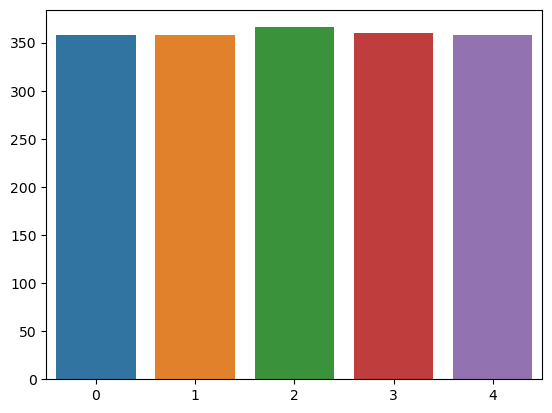

In [105]:
q_animate = Queue()
game = explore.ExploreGame(21, False, False, 0)
q_animate.put((game.generate_frame(), game.get_trace()))
view_args = [q_animate, "Explore", 5, 20, 21, 600, 30]
viewer = Process(target=explore.launch_viewer, args=view_args)
viewer.start()
time.sleep(2)

pos = np.random.randint(0, 5)
length = np.random.randint(1,10)
count = 0
switched = 0
tracking = np.zeros(5)


for i in range(30*60):
    game.update(pos)
    tracking[pos] += 1
    q_animate.put((game.generate_frame(), game.get_trace()))
    count += 1
    if count >= length:
        pos = (pos + 1)%5
        switched += 1
        count = 0
    if switched == 5:
        pos = np.random.randint(0, 5)
        length = np.random.randint(1,11)
        count = 0
        switched = 0
    time.sleep(1/60)
q_animate.put("kill")
sns.barplot(x = np.arange(5), y=tracking)

Your eyes do not deceive you. Again we have another example where we have technically maximized the VoA of our selection process. But this isn't a sleection process we would actually want, right? The actual behavior of the agent is hardly "random".

The algorithm is actually quite deterministic. It makes a random roll to seed a fully predictable process. In this case taking a "circular path", always left handed, and pickinga new random starting direction after each loop.

If length is 1, only 20% or 1 out of every 5 moves is actually random, if length is 10 then 1 out of 50 or 2% of moves are random.

So if we know these processes are not the same, and we know all 3 algorithms have the same maximized VoA then maybe there is a problem with simply maximizing the VoA and calling it good. Maybe there are some false assumptions or missed considerations. The VoB of the algorithms is different and as mentioned not "simply" quantifiable.

So how do we quantify which is better?

Well I would like to propose that simply maximizing the VoA is nto good enough. What we actually want is to maximize the VoB. Well more specifically we do want to maximize the VoA, but that does not maxmize our benefit from how we choose actions on its own.

Recall the two main reasons for maximizing VoA, and thus the naive approach of uniform probability for sleections are:
 1. Create and unbiased selection of actions, to not inluence the policy network in any one direction
 2. To create a maximum amount of variance in the Agent's Experiences for the most robust exploration
 
The first of these is indeed met by simply maximizing the VoA. By ensuring a generally uniform distribution of moves, we do eliminate a random bias for any one move in the selection process. But it also doesn't eliminate all biases.

But it is my proposal that maximizing the VoA does not actually accomplish the second goal. It sounds like it does, but it doesn't. This is where the justifcation is acepted at face value.

Lets define a behavior as some unique order of moves in whatever game. The actions correspond to numbers like this:
 0 = up
 1 = left
 2 = down
 3 = right
 4 = stay still
 
 Our circle turning algorithm produces sequencess of moves that then look like:
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 0, 0, 0, . . .] 
 But more generally, where i is the random starting direction for the sequence
 ([i, i, (i+1), (i+1), (i+2), (i+2), (i+3), (i+3), (i+4), (i+4), i, i,  . . .]) % 5
 where the repetition is determined by the length value.
 
 So more mathematically, the 0 indexed nth term of a sequence with length l and starting term a looks like
 (a + k//l)%5
 Recall in python notation // is integer division and % is mod
 To check ourselves lets plug in values form the first series, a = 0 and l is 3
 the first term is k = 0
 k = 0 : (0 + 0//3)%5 = 0
 k = 3 : (0 + 3//3)%5 = 1
 k = 11 : (0 +  11//3)%5 = 3
 k = 15 : (0 + 15//3)%5 = 0
 Run the cell below if you are not conviced this makes our sequences, and yes this is a more efficent way to implement the code above.

In [109]:
a = 2
l = 4
for k in range(32):
    print((a + k//l)%5, end=", ")

2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 

So if that is a "circular" behavior then something like
0, 0, 0, 1, 2 ,2, 2, 1, 0, 0 ,0 . . .
would be a thin zig zag heading left
0,1,2,1,0 . . .
Would be even thinner. Hopefully this makes sense, rememeber the sequence means, up, left, down, left, up, left and so on.

So our first problem is that a maximized VoA may eliminate bias towards any one specific move, put another way it minimizes the Bias of Actions (BoA). But it doesn't elimante all bias, intrinsicly.

Our circle turning algorithm is a prime example. We know the distribution of actions is uniform, but would you say the behavior is unbiased? It strictly makes left handed circular paths. The only variation comes from the radius of the circle and the starting direction. Meaning we actually have a minimal variance in our sequences, and therefore behavior. 

We are starting to get to the core of the issue here. Now we can discuss if the standard approach gives us the a maximum variation in behavior, and if not, can we do better, and is it worth our time?

The naive approach looks like this in code.
np.random.choice(np.arange(5))
Giving us the options to select 0 - 4 as actions with equal probability of choosing any of those values. So what is the probability of ever seeing any one particular behavior? Can we expect our agent to frequently exhibit a circular path? Or a zig zag?

Well what is the expected movement of our agent given this process? Think expected value but for our movement vector. We have a 20% chance * our action vectors [0,1] and [0, -1] for down and up for example. The .2 is equal for all outcomes so our expected movement is the sum of all 5 movement vectors multiplied by .2. But the sum is equal to 0. So statistically, and this is true for every algorithm witha uniform distribution of moves, our agent should go nowhere.

You saw this watching the demo of course where you might have noticed the agent in demo_1 tends to "linger" wherever it is and periodically may shioft around. That random shift ocurrs soley by luck.

The probability of moving 4 tiles away from a given position in 4 moves is (1/5)^4 and the further we wish to go the less likely it becomes. The standard solution's problem is that it allows for immediate reversals of previously made decisions.

Allowing reversals by itself is not a bad thing, it is also tied to other behaviors, but the problem is it ALWAYS allows for reversals at an equal probability.

So what we need now is a way to measure the quality of various selection algorithms. A way to measure, or at least estimate our VoB, emperically as opposed to observationally.

This means we need to discuss briefly about reward functions, and about the variance in our heat maps. The reality here is that depending on the complexity of our environment or model architecture, exactly how to estimate this will fall into the categories of hyperparameter optimization and feature engineering. Ideally this would be roughly optimized before model training really begins but it does become a step of its own. We will go through that in more detail very soon.

So in RL it is very common to have a sparse reward function. This means we want reward function that give feedback, rewards, at as few stages as possible. This is in its own regard an attempt to avoid bias. We are in general trying to have the model find an optimal policy because we don't know the optimal policy ourselves. But writing the perfect reward function would require already knowing the correct policy.

The solution then is to only give rewards for doing something explicitly bad or good. And preferably as infrequently as possible. Think, only telling the computer its reward when it loses, wins, or draws a game of chess, and maybe when it tries to make an illegal move. If we deviate from this set up then we run the risk of biasing our model.

For example if we know the move E4 is a decent move and give a reward for making that move, our model will be pressured into making that move over anyother move that doesn't have a bonus reward. Which then requires us to define rewards for all other moves, proportional in value to E4. And well, we are simply defining the policy at that point.

At the same time however this sparse reward can cause a problem in getting the model to ever "see" or receive the rewards. A problem will discuss a bit more in a moment.

We can also measure the variance in our heat maps from our simulations. Rememeber the heatmap's values are the frequency of the agent being on that square. So we can measure how evenly our agent explored the space. To do this we can use numpy, recall that the variance is just the standard deviation squared so we can compare.

In [111]:
print("Sample_1 : ", heat_1.std()**2)
print("Sample_2 : ", heat_2.std()**2)
print("Sample_2 / Sample_1 : ", (heat_2.std()/heat_1.std())**2)

Sample_1 :  1043.1179427553334
Sample_2 :  774.9346626405666
Sample_2 / Sample_1 :  0.7429022461195741


So here I have been telling you we want to maximize variance and now the one I am telling you is better has lower variance? Well I did tell you the word variance was going to get thrown aorund a lot, and that it was going to be confusing.

What we need to keep in mind is the distinction about what we are actualy trying to optimize versus what we can measure. If we were to imagine what the heatmap would look like for some ideal selection algorithm, what would it look like?

Remeber what we want is the maximum number of different "expereinces" for the model to learn from. So one might imagine that the ideal distribution would be UNIFORM. Meaning we want an algorithm that comes as close as possible (maybe) to exploring every square about the same number of times.

Of course given the rules of the game this is simply not possible as the player always spawns at the center of the map. So the environment itself is biasing the exploration to the center. and you may be thinking, just change the rules, allow different spawning points, as a solution.

While it is true that could help solve some of our problems it also means changing the game. With a simple game like Explore this would be trivial but Explore is intended as our simple case and may not always be a viable option. Consider a linear RPG with key/item requirements to access certain areas or defeat certain enemies. You are now obligated to solve continuity issues to make the idea worth it.

This has been a long secontion of text and I don't want to bore you, so lets get some more examples to advance our discussion. Run the next code block to set up some parameters for some sims we will be running. Please read the comments to understand what each one does. and there are some notes below if you encounter any problems.

To help run these quite a bit faster I multiprocess our simulations, but Jupyter doesn't play nice, especially with the join() method. So understand, if you go looking at the code, it is not an ideal or proper multiprocessing implementation.

If your computer struggles with later sims, reduce max_processors. It can't go below one though. 
As we start running multiple games at once, I have shrunk the windows. The size of 300 should work on screens with resolutions 1080p or higher, if you run into issues you can make them smaller or bigger as desired. Be warned, larger game board sizes and small windows can make the animation not viewable. If you want to make the screens bigger you can also reduce max_processors. This will make things more visible but slow down the run time. 

In [115]:
max_processors = min(8, max(1, multiprocess.cpu_count()//2)) # the maximum number of sims to run at once
# for convienince the value of max_processors will only be set once
#Game params
game_size = 21 # the width of the game board, 21 is the default
use_maze = False # wether or not the map should include walls
use_exclusion = False # a rule constraining the spawn location of the goal, default is True
use_noise_boundary = 0 # prevents the first step of maze generation from beging, 
                       # this value's distance from the edge, so 0 is off and 2 is default
game_sparsity = .8 # the minimum value of the sparisty of the initial noise pattern for map generation.
                   # Smaller means more walls on average

game_args = [game_size, use_maze, use_exclusion, use_noise_boundary, game_sparsity]

game_window_size = 600 # the height of viewer window. 300 should work for organizing windows on screens 1080p or larger 
game_window_framerate = 60 # The polling rate of the viewer for new frames to draw

window_args = [game_window_size, game_window_framerate]

# The simulation speed is going to exponentially increase to save time, this can look chaotic
out = sim_1([Chooser(5)], samples=1000, games=10, turns=40, num_process=8, num_column=3, env_args=game_args, window_args=window_args)

In [27]:
choosers = []
choosers.append(Chooser(5))
if False:
    for i in range(3, 13):
        choosers.append(Chooser(5, [0,10,7.5,5,0], i))
    for i in range(3, 13):
        choosers.append(Chooser(5, [10,10,10,10,10], i))
    for i in range(3, 13):
        choosers.append(Chooser(5, [1,10,10,10,0], i))
else:
    choosers.append(Chooser(5, [0, 10, 7.5, 5, 0], 6))
    choosers.append(Chooser(5, [0, 10, 7.5, 5, 0], 4))
    choosers.append(Chooser(5, [0, 10, 7.5, 5, 0], 5))
    choosers.append(Chooser(5, [1, 10, 10, 10, 0], 7))
len(choosers)

5

In [28]:
out = sim_1(choosers, samples=1000, games=10, turns=40, num_process=8, num_column=3, env_args=game_args, window_args=window_args)

In [29]:
results = out

In [30]:
for k in range(len(results)):
    max_winrate = 0
    pos = 0
    for i in range(k, len(results)):
        if results[i][2][0] > max_winrate:
            max_winrate = results[i][2][0]
            pos = i
    temp = results[k]
    results[k] = results[pos]
    results[pos] = temp

In [31]:
for i in range(len(results)):
    print(results[i][2][0])

0.231
0.228
0.216
0.175
0.088


In [19]:
weights = []
durations = []
win_data = []
stdev_data = []
trace_averages = []
for result in results:
    weights.append(result[0])
    durations.append(result[1])
    win_data.append(result[2])
    stdev_data.append(result[3])
    trace_averages.append(result[4])

In [20]:
for (w, d, r) in zip(weights, durations, win_data):
    print(d, w, f"{r[0]:.4}", f"{r[2]:.3}", " <--> ", f"{r[0] - r[2]:.4}", " - ", f"{r[0] + r[2]:.4}")

7 [1, 10, 10, 10, 0] 0.977 0.0326  <-->  0.9444  -  1.01
5 [0, 10, 7.5, 5, 0] 0.946 0.0319  <-->  0.9141  -  0.9779
4 [0, 10, 7.5, 5, 0] 0.933 0.0302  <-->  0.9028  -  0.9632
6 [0, 10, 7.5, 5, 0] 0.895 0.0312  <-->  0.8638  -  0.9262
-1 None 0.732 0.0269  <-->  0.7051  -  0.7589


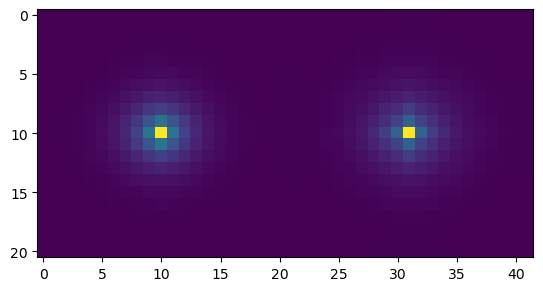

In [13]:
temp = np.hstack([trace_averages[-2], trace_averages[0]])
plt.imshow(temp)

In [43]:
mins = np.zeros(len(trace_averages))
for i in range(len(trace_averages)):
    mins[i] = trace_averages[i].min()
mins.mean()

1.4395645161290322

In [44]:
mins.std()

0.5024933281844916

In [38]:
trace_averages[-1].max()

524.6467

In [39]:
trace_averages[0].max()

489.7545

In [ ]:
#6 [0, 10, 7.5, 5, 0] 7.37 0.0274  <-->  7.343  -  7.398
#4 [0, 10, 7.5, 5, 0] 7.354 0.0276  <-->  7.326  -  7.381
#5 [0, 10, 7.5, 5, 0] 7.318 0.0275  <-->  7.291  -  7.346
#7 [1, 10, 10, 10, 0] 7.31 0.0277  <-->  7.282  -  7.337

In [10]:
win_averages = []
win_stds = []
win_errors = []
for win in win_data:
    win_averages.append(win[0])
    win_stds.append(win[1])
    win_errors.append(win[2])

In [11]:
stdev_averages = []
stdev_stds = []
stdev_errors = []
for stdev in stdev_data:
    stdev_averages.append(stdev[0])
    stdev_stds.append(stdev[1])
    stdev_errors.append(stdev[2])

In [12]:
for (mean, error) in zip(stdev_averages, stdev_errors):
    print(mean, error)

21.915006421778063 0.10708246384246096
15.2103472534303 0.08477570267273185
16.418986514123485 0.08330403448770658
17.957885942316455 0.082570717415026
19.480932797157642 0.08758232776463426
21.781383165100706 0.09574792182765507
15.629925028396283 0.08976795817382
13.687060319755307 0.06589713849537174
14.736647638912821 0.08364109341070006
14.072948662005137 0.08261498998746902
13.682836146118154 0.09185016762984498
14.127084552989043 0.08014547039543578


In [3]:
ch1 = Chooser(5)
ch2 = Chooser(5, [1,10,10,10,1])

In [5]:
lol1 = Process(target=simulate_explore, args=[sem, out_lock, output_queue, 100,100,40, ch1, 15, 1.08])
lol2 = Process(target=simulate_explore, args=[sem, out_lock, output_queue, 100,100,40, ch2, 15, 1.08])

In [6]:
lol1.start()
lol2.start()

In [8]:
lol1.join()
lol2.join()

In [10]:
list = []
if list:
    print("hi")